# Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import warnings
%matplotlib inline
from datetime import datetime
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
rcParams['figure.figsize'] = 15, 6

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Michael/Desktop/Data/Bitcoin.csv')

In [3]:
print(df.head())
print('\n Data Types:')
print(df.dtypes) 

         DATE    CBCCIND
0  2015-01-09  97.613965
1  2015-01-16  71.870194
2  2015-01-23  68.418913
3  2015-01-30  78.727410
4  2015-02-06  72.073471

 Data Types:
DATE        object
CBCCIND    float64
dtype: object


In [4]:
print(df.head())

         DATE    CBCCIND
0  2015-01-09  97.613965
1  2015-01-16  71.870194
2  2015-01-23  68.418913
3  2015-01-30  78.727410
4  2015-02-06  72.073471


In [5]:
df.index

RangeIndex(start=0, stop=205, step=1)

# Stationarity of a Time Series

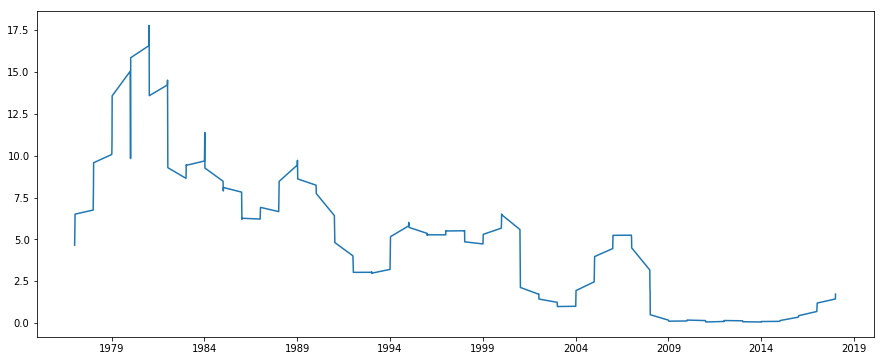

In [225]:
plt.plot(ts)

In [226]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

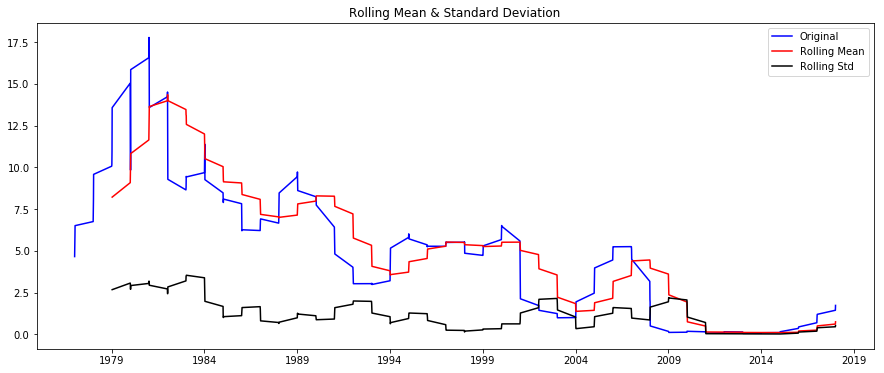

Results of Dickey-Fuller Test:
Test Statistic                  -1.554689
p-value                          0.506305
#Lags Used                       7.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


In [227]:
test_stationarity(ts)

# Estimating & Eliminating Trend

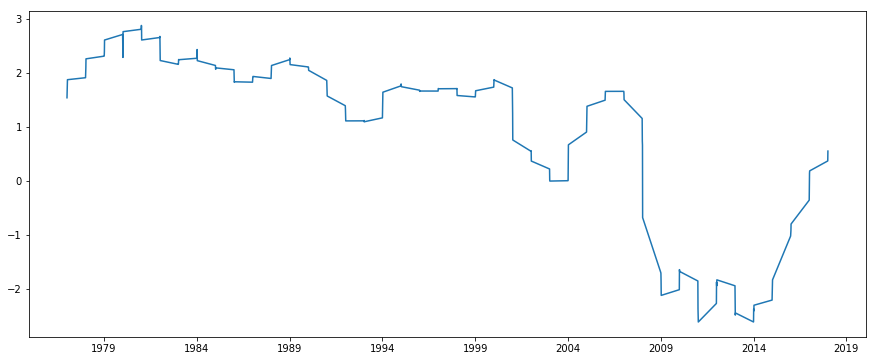

In [228]:
ts_log = np.log(ts)
plt.plot(ts_log)

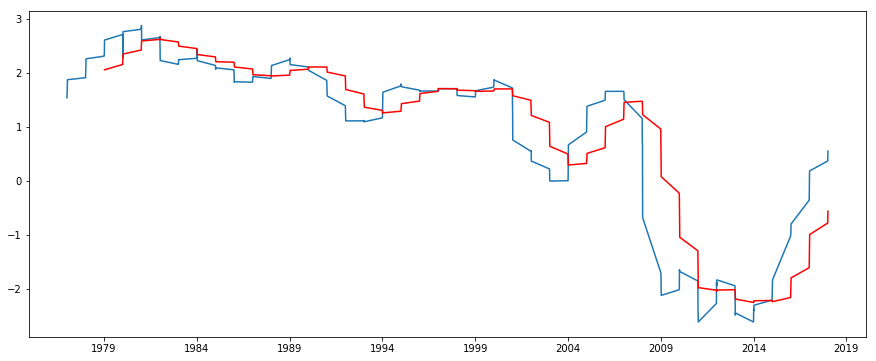

In [229]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [230]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

DATE
1977-01-01         NaN
1977-01-04         NaN
1977-01-07         NaN
1977-01-10         NaN
1978-01-01         NaN
1978-01-04         NaN
1978-01-07         NaN
1978-01-10         NaN
1979-01-01         NaN
1979-01-04         NaN
1979-01-07         NaN
1979-01-10    0.550505
Name: FEDFUNDS, dtype: float64

# Moving Average

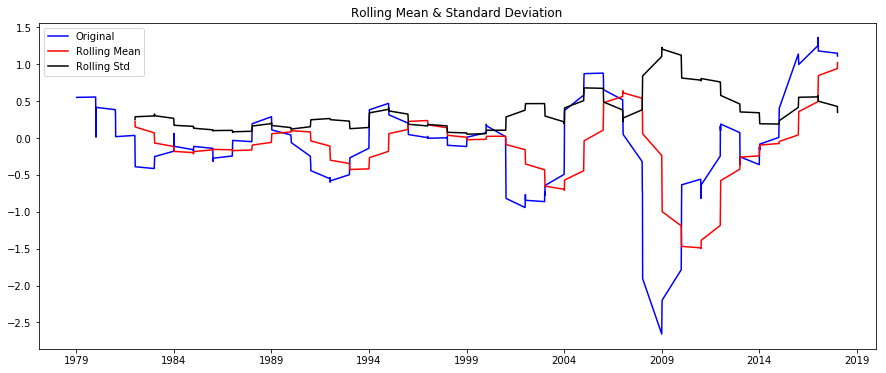

Results of Dickey-Fuller Test:
Test Statistic                  -3.799385
p-value                          0.002914
#Lags Used                       3.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [231]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

## Exponential Weighted Moving Average

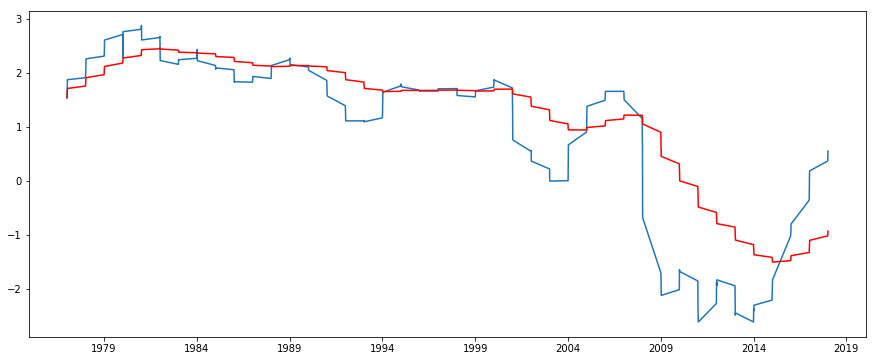

In [232]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

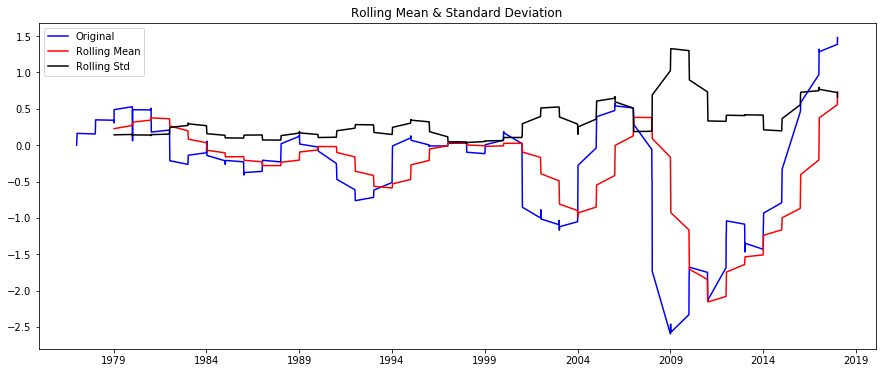

Results of Dickey-Fuller Test:
Test Statistic                  -2.833005
p-value                          0.053712
#Lags Used                       3.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64


In [233]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

# Eliminating Trend and Seasonality

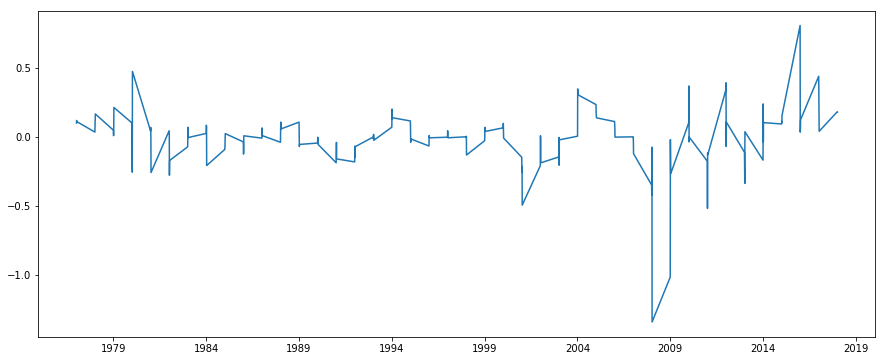

In [234]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

## Differencing

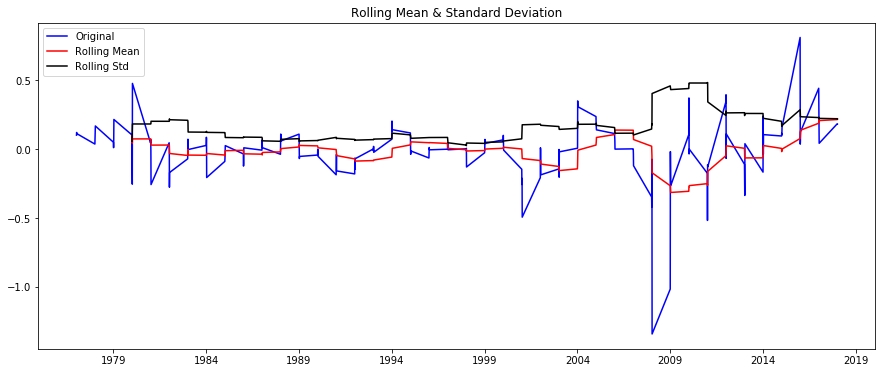

Results of Dickey-Fuller Test:
Test Statistic                  -4.691676
p-value                          0.000087
#Lags Used                       2.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64


In [235]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Decomposing

In [236]:
decomposition = seasonal_decompose(ts_log, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

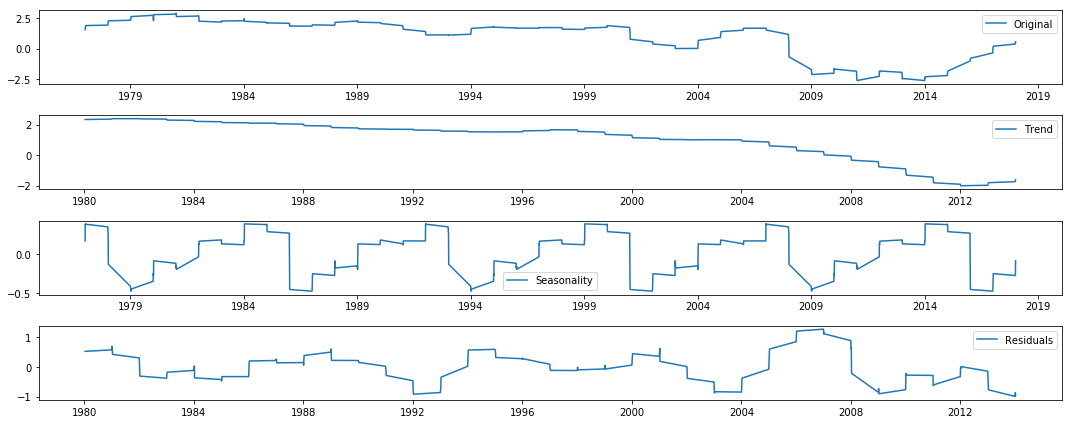

In [237]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

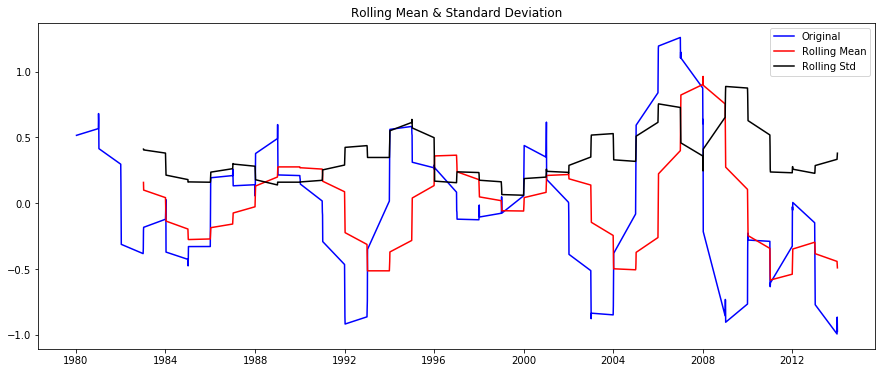

Results of Dickey-Fuller Test:
Test Statistic                  -4.669025
p-value                          0.000096
#Lags Used                       3.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [238]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Forecasting a Time Series

In [239]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

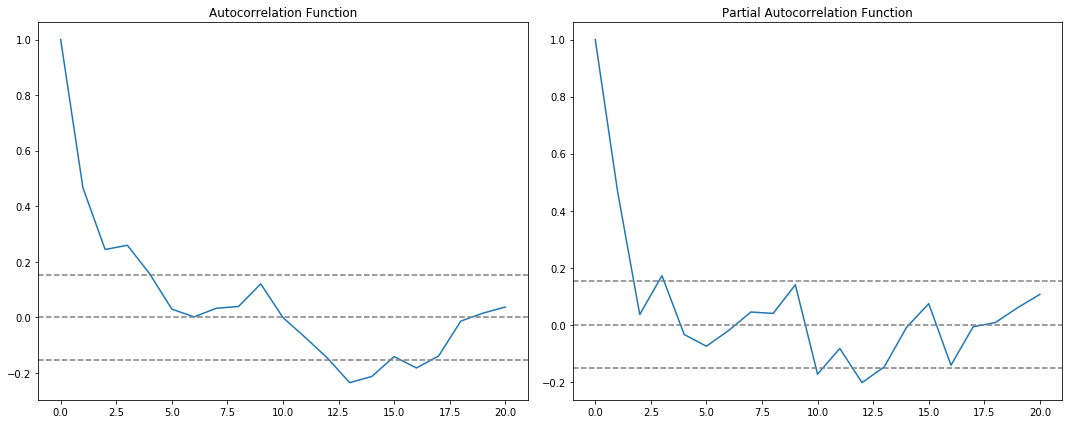

In [240]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# AR Model

Text(0.5,1,'RSS: 5.7671')

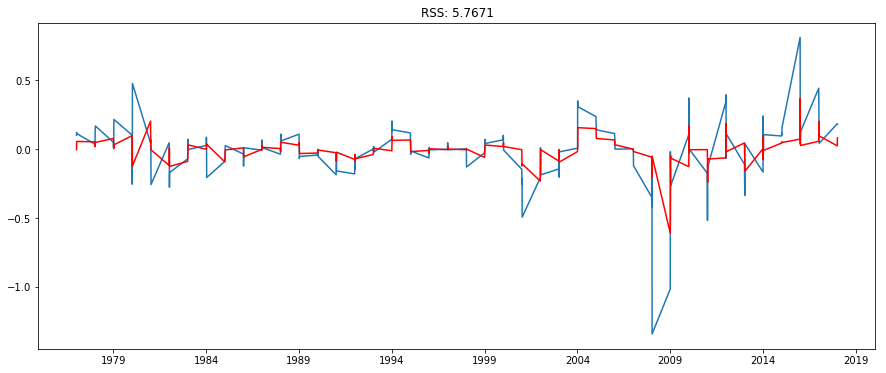

In [241]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

# MA Model

Text(0.5,1,'RSS: 5.8946')

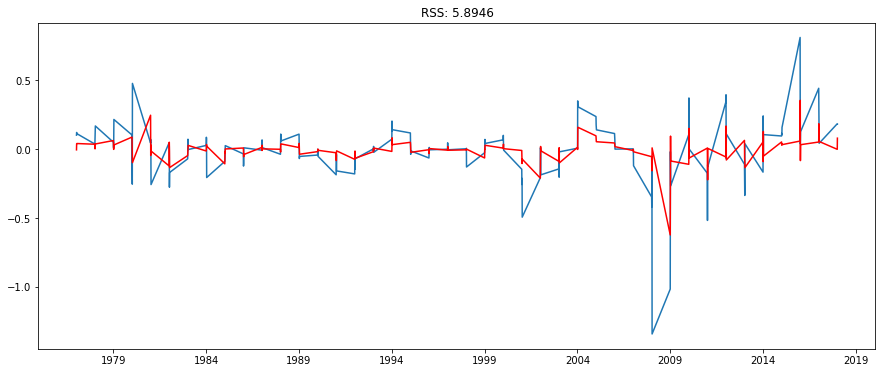

In [242]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

# AR & MA Combined

Text(0.5,1,'RSS: 5.5584')

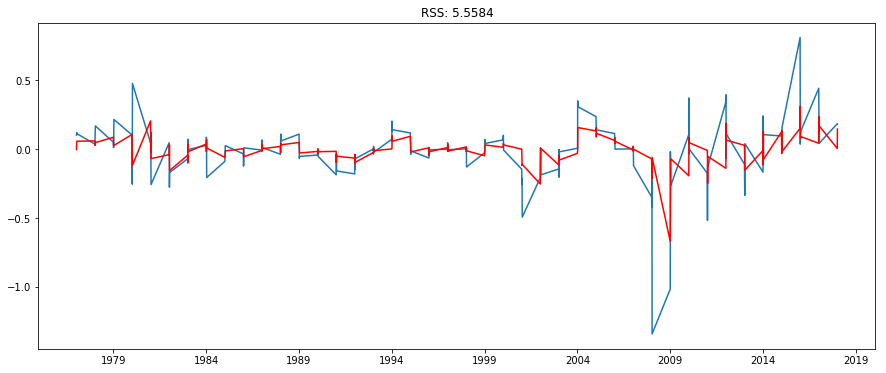

In [243]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [245]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

DATE
1977-01-04   -0.003028
1977-01-07    0.045330
1977-01-10    0.057436
1978-01-01    0.059807
1978-01-04    0.027493
dtype: float64


In [247]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

DATE
1977-01-04   -0.003028
1977-01-07    0.042302
1977-01-10    0.099739
1978-01-01    0.159546
1978-01-04    0.187039
dtype: float64


In [248]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
1977-01-01    1.539015
1977-01-04    1.535988
1977-01-07    1.581318
1977-01-10    1.638754
1978-01-01    1.698561
dtype: float64

Text(0.5,1,'RMSE: 2.1662')

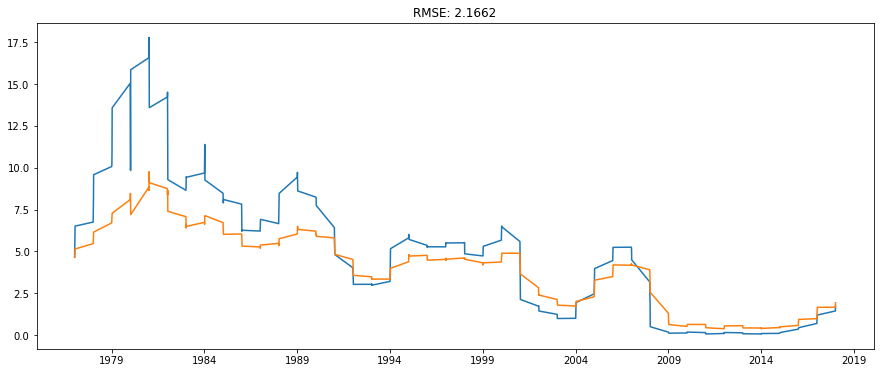

In [249]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))